<h1>Vision Transformer</h1>

In this notebook we implement the vision transformer by paddlepaddle on CIFAR100. 在本笔记本中我们在CIFAR100数据集上利用飞桨实现 Vision Transformer.

Author:      [个人主页](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/550143) $\quad$
[GitHub](https://github.com/ForeverHaibara)

Original paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Top1 Acc 预测准确率 $\approx 50\%$

Time 执行时间 $\approx 25{\rm \ min}$

In [28]:
import numpy as np
import paddle 
from matplotlib import pyplot as plt 
from tqdm import tqdm 

<h2>Data Preparation</h2>

Load the CIFAR100 data from the cifar-100-python.tar.gz and we implement the CutMix for data augmentation. 从 cifar-100-python.tar.gz 中加载数据集并实现 CutMix 的数据增强.

In [ ]:
#!gzip -dfq /home/aistudio/data/data76994/cifar-100-python.tar.gz
#!tar -xf /home/aistudio/data/data76994/cifar-100-python.tar

In [ ]:
def load_data(path):
    import os
    import pickle
    with open(os.path.join(path,'train'), 'rb') as f:
        data_train = pickle.load(f, encoding='latin1')
    with open(os.path.join(path,'test'), 'rb') as f:
        data_test = pickle.load(f, encoding='latin1')
    with open(os.path.join(path,'meta'), 'rb') as f:
        data_meta = pickle.load(f, encoding='latin1')
    return data_train, data_test, data_meta

data_train, data_test, data_meta = load_data('cifar-100-python')
data_train['data'] = data_train['data'].reshape((data_train['data'].shape[0], 3, 32, 32)).transpose((0,2,3,1))
data_test['data'] = data_test['data'].reshape((data_test['data'].shape[0], 3, 32, 32)).transpose((0,2,3,1))

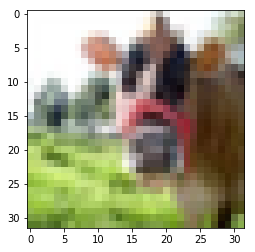

In [ ]:
# see an example
plt.imshow(data_train['data'][0])
plt.show()

In [26]:
import numpy as np
import paddle
from tqdm import tqdm 
from PIL import Image 
def augmentate(pics, labels = None, resize = (224, 224), augmentation = False, 
                cut = False, mix = False, grid = 0, rotate = 15):
    '''Simple data augmentator'''
    pics2 = []
    n = pics.shape[0]
    if resize is None:
        resize = pics[0].shape 
    
    if augmentation:
        angles = (np.random.random(n) - .5) * (rotate * 2.)
        flips = np.random.randint(0, 2, n)
        for i in range(n):
            pic = Image.fromarray(pics[i])
            if flips[i]: pic = pic.transpose(Image.FLIP_LEFT_RIGHT)
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = pic.rotate(angles[i])
            pic = np.array(pic)
            pics2.append(pic)
    
        if cut and not mix:
            # cutout
            if not grid: grid = 1
            cutx = np.random.randint(cut, resize[0], n) // grid * grid
            cuty = np.random.randint(cut, resize[1], n) // grid * grid
            for i in range(n):
                pics2[i][cutx[i]-cut : cutx[i], 
                         cuty[i]-cut : cuty[i], : ] = 0
            labels *= (1. - cut * cut / pics2[0].size * 3.)

        elif mix and not cut:
            # mixup
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)

            # warning: do not modify in-place
            pics3 = [propotion[i] * pics2[couple[i]] + (1 - propotion[i]) * pics2[i] 
                        for i in range(n)]

            # pointer
            pics2 = pics3 

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))

        elif cut and mix:
            # cutmix
            couple = np.arange(n)
            np.random.shuffle(couple)
            if not grid:
                propotion = np.random.random(n)
                rw = (resize[0] * np.sqrt(propotion)).astype('uint8')
                rh = ((resize[1] / resize[0]) * rw).astype('uint8')
                grid = 1
            else:
                propotion = np.full(n, cut * cut / pics2[0].size * 3.)
                rw = np.full(n, cut, dtype='uint8')
                rh = np.full(n, cut, dtype='uint8')
            
            rx = np.random.randint(65535, size = n) % ((resize[0] - rw) // grid) * grid 
            ry = np.random.randint(65535, size = n) % ((resize[1] - rh) // grid) * grid 

            # warning: do not modify in-place
            pics3 = np.array(pics2)
            for i in range(n):
                pics3[i][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] = \
                    pics2[couple[i]][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] 

            # pointer
            pics2 = pics3

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))
            
    else: 
        # no augmentation but resizing
        for i in range(pics.shape[0]):
            pic = Image.fromarray(pics[i])
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = np.array(pic)
            pics2.append(pic)

    return np.array(pics2), labels
 

def dataloader(data, labels, batch_size = 128, shuffle = True, verbose = True,
                resize = (224,224), augmentation = True, onehot = False,
                cut = False, mix = False, grid = 0, rotate = 15):
    order = np.arange(data.shape[0], dtype = 'int32')
    if shuffle: np.random.shuffle(order)
    labels = np.array(labels)
    __eye = np.eye(np.max(labels) + 1)
    gen = range(data.shape[0] // batch_size)
    if verbose: gen = tqdm(gen)
    for i in gen:
        x = data[order[i * batch_size: i * batch_size + batch_size]]
        l = labels[order[i * batch_size: i * batch_size + batch_size]]

        # extract the onehot encoding
        l = __eye[l]

        # augmentate the data
        x , l = augmentate(x, l, resize = resize, augmentation = augmentation, 
                            cut = cut, mix = mix, grid = grid, rotate = rotate)

        # transpose the dimensions to match (N,C,H,W)
        x = x.transpose((0,3,1,2))
        x = paddle.to_tensor(x, dtype = 'float32') / 255.

        # retrieve the non-onehot encoding if asked
        if not onehot:
            l = labels[order[i * batch_size: i * batch_size + batch_size]]
        yield x , l


def topk(y, labels, top):
    '''compute the number of hits in the top-k prediction'''
    topy = np.argpartition(y, -top, axis=-1)[:,-top:]
    topy -= labels.reshape((labels.shape[0], 1))
    return topy.size - np.count_nonzero(topy)


def test(net, data, batch_size = 100, resize = (224,224), tops = [1,5],
            verbose = False, label = 'fine', augmentation = False):
    accs = [0] * len(tops)
    tops.sort()
    for x, labels in dataloader(data['data'], data[f'{label}_labels'], resize = resize, 
                                  batch_size = batch_size, shuffle = False, verbose = verbose,
                                  augmentation = augmentation):
        y = net(x).numpy()
        labels = np.array(labels)
        for i in range(len(tops)):
            t = topk(y, labels, tops[i])
            accs[i] += topk(y, labels, tops[i])
    return np.array(accs) / data['data'].shape[0]

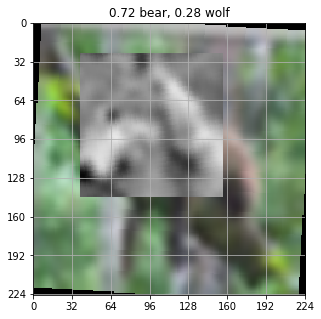

In [ ]:
# visualize CutMix
resize = (224, 224)
cut = 128
grid = 32
plt.figure(figsize=(5,5))
for x, labels in dataloader(data_train['data'], data_train['fine_labels'], verbose = False, 
                            resize = (224, 224), cut = cut, mix = 1, grid = 0, onehot = True):
    plt.imshow(x[0].transpose((1,2,0)))
    plt.title(''.join([('%.2f %s, '%(p, data_meta['fine_label_names'][index]) if p > 0 else '')
                            for index, p in enumerate(labels[0])])[:-2] )
    ax = plt.gca()
    ax.set_xticks(np.arange(-1, resize[0], grid))
    ax.set_yticks(np.arange(-1, resize[1], grid))
    ax.set_xticklabels(np.arange(0, resize[0]+1, grid))
    ax.set_yticklabels(np.arange(0, resize[1]+1, grid))
    plt.grid()
    break

<h2>Transformer</h2>

Build a vision transformer (vit). 搭建 Vision Transformer.

In [ ]:
# Reproduce of vision transformer in paddlepaddle

import paddle   
import numpy as np

# class Encoder
# class MultiheadAttention
# class MLP
# class VisionTransformer


class Encoder(paddle.nn.Layer):
    def __init__(self, channels, hidden_size, num_heads = 3, linear_dropout = .1, attention_dropout = .1):
        # num_heads == patch_num
        super().__init__()
        
        self.layer_norm1 = paddle.nn.LayerNorm(channels)

        # self.attention   = paddle.nn.MultiHeadAttention(
        #                                 embed_dim = channels, 
        #                                 num_heads = num_heads, 
        #                                 dropout = attention_dropout)

        self.attention   =  MultiheadAttention(
                                        embed_dim = channels, 
                                        num_heads = num_heads, 
                                        dropout = attention_dropout)

        self.layer_norm2 = paddle.nn.LayerNorm(channels)

        self.mlp         = MLPLayer(channels, hidden_size, dropout = linear_dropout)


    def forward(self, x):
        y = self.layer_norm1(x)
        y = self.attention(y)

        x = x + y 

        y = self.layer_norm2(x) 
        y = self.mlp(x) 

        return x + y



class MultiheadAttention(paddle.nn.Layer):
    def __init__(self, num_heads = 3, embed_dim = 192, dropout = 0.):
        super().__init__() 
        
        assert embed_dim % num_heads == 0, 'Embedding dimension must be divisible by number of heads.'

        self.num_heads = num_heads
        
        # map the input to qkv
        self.qkv = paddle.nn.Linear(embed_dim, embed_dim * 3)

        self.dropout = paddle.nn.Dropout(dropout)

        self.attention = None
    
    def forward(self, x):
        n, length, embed_dim = x.shape

        # map the input to qkv
        # [n, length, embed_dim] -> [n, length, embed_dim * 3]
        x = self.qkv(x) 

        # partition x into qkv and distribute embeddings to heads
        # [n, length, embed_dim * 3] -> [3, n, heads, length, embed_dim / heads]
        x = x.reshape((n, length, 3, self.num_heads, embed_dim // self.num_heads))
        x = x.transpose((2, 0, 3, 1, 4))
            
        q, k, v = x[0], x[1], x[2]

        # first matmul (remember to transpose k)
        attention = paddle.matmul(q, k.transpose((0,1,3,2)))

        # scale the attention
        attention = attention * (q.shape[-1] ** -0.5)

        # softmax 
        # we store it because it is useful when visualizing
        self.attention = paddle.nn.Softmax(axis = -1)(attention)

        # dropout
        attention = self.dropout(self.attention)

        # second matmul, shape = [n, heads, length, embed_dim / heads]
        x = paddle.matmul(attention, v)

        # restore shape
        # [n, heads, length, embed_dim / heads] -> [n, length, embed_dim]
        x = x.transpose((0, 2, 1, 3)).reshape((n, length, embed_dim))

        return x



class MLPLayer(paddle.nn.Layer):
    def __init__(self, input_size, hidden_size, output_size = None, dropout = .1):
        """An MLP layer consists of two linear layers followed with dropout."""
        super().__init__()

        output_size   = output_size or input_size 
        
        self.dense1   = paddle.nn.Linear(input_size, hidden_size, 
                                        weight_attr = paddle.nn.initializer.XavierUniform())
        self.act1     = paddle.nn.LeakyReLU()
        self.dropout1 = paddle.nn.Dropout(dropout)


        self.dense2   = paddle.nn.Linear(hidden_size, output_size, 
                                        weight_attr = paddle.nn.initializer.XavierUniform()) 
        #self.act2     = paddle.nn.LeakyReLU()
        self.dropout2 = paddle.nn.Dropout(dropout)


    def forward(self, x):
        x = self.dense1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.dense2(x)
        # x = self.act2(x)
        x = self.dropout2(x)

        return x



class VisionTransformer(paddle.nn.Layer):
    def __init__(self, input_size = 224, output_size = 100,
                        channels = 192, hidden_size = 768,
                        patch_size = 16, 
                        num_heads = 3, encode_layers = 12, 
                        pos_encoding = True,
                        linear_dropout = 0., attention_dropout = 0., encoding_dropout = 0.):
        """
        Vision Transformer

        Parameters
        --------
        input_size   : int, the input image should be of size input_size * input_size
        output_size  : int, the number of classes to classify
        channels     : int, the embedding dimension
        hidden_size  : int, the size of hidden layer in MLP
        patch_size   : int, the size of a patch
        num_heads    : int, number of heads
        encode_layers: int, number of encoders
        pos_encoding : bool, whether or not use the positional encoding
        linear_dropout   : float, dropout rate in MLP
        attention_dropout: float, dropout rate in multihead attention
        encoding_dropout : float, dropout rate after positional encoding


        Reference: 
        https://arxiv.org/abs/2010.11929 
        """
        super().__init__()

        assert input_size % patch_size == 0, 'Input size must be divisible by patch size.'
        self.input_size = input_size
        self.patch_size = patch_size

        # convolution on each patch is the projection
        self.proj = paddle.nn.Conv2D(in_channels = 3, out_channels = channels,
                                     kernel_size = patch_size, stride = patch_size,
                                     padding = 'VALID')

        # num of patches
        patch_num = (input_size // patch_size) ** 2 

        # class tokens and (learnable) positional encodings
        self.params = paddle.nn.ParameterList(
                        [paddle.create_parameter((1, 1, channels),dtype = 'float32'),
                         paddle.create_parameter((1, patch_num + 1, channels),dtype = 'float32')]
                                                )
        self.cls_token = self.params[0]
        self.pos_encoding = pos_encoding and self.params[1]

        self.dropout = paddle.nn.Dropout(encoding_dropout)

        self.encoders = paddle.nn.LayerList(
                                [Encoder(channels  = channels,
                                 hidden_size       = hidden_size,
                                 num_heads         = num_heads,
                                 linear_dropout    = linear_dropout,
                                 attention_dropout = attention_dropout) for _ in range(encode_layers)]
                                            )
        
        self.layer_norm = paddle.nn.LayerNorm(channels)

        self.head = paddle.nn.Linear(channels, output_size)


    def forward(self, x):
        """Input: paddle tensor x with shape [batch_size, 3, height, width]"""
    
        # [batch_size, 3, height, width] -> [batch_size, channels, patch_x, patch_y] by conv
        x = self.proj(x)  

        # [batch_size, channels, patch_x, patch_y] -> [batch_size, channels, patch_num]
        x = paddle.flatten(x, 2, 3)

        # [batch_size, channels, patch_num] -> [batch_size, patch_num, channels]
        x = x.transpose((0,2,1))
        
        # [batch_size, patch_num, channels] -> [batch_size, patch_num + 1, channels]
        cls = paddle.tile(self.cls_token, (x.shape[0], 1, 1))
        x = paddle.concat([cls, x], axis = 1)

        # positional encoding
        if self.pos_encoding is not None:
            x = x + self.pos_encoding
        x = self.dropout(x)
        
        # encoders
        for i in range(len(self.encoders)):
            x = self.encoders[i](x)
        
        # layernorm
        x = self.layer_norm(x)

        # reserve the first "patch"
        x = x[:, 0]

        # linear classifier
        x = self.head(x)

        return x


    def visualize(self, x, layer = 0, dtype = 'int'):
        """
        Visualize the attention-guided image of some x with some of the encoders.

        Parameters
        --------
        x    : 4darray, input images with [N,C,H,W] format (C=3) and entries in [0,1]
        layer: int, the index of attention map for visualization (starting from 1, defaults to the last)
        dtype: str, 'int' or 'float' for the dtype of returned images

        Returns
        --------
        imgs     : 4darray, [N,C,H,W] formatted rgba images (C=4)
        attention: 3darray, [N,H,W] formatted, with entries in [0,1]

        Reference:
        https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb 
        """
        
        if not layer: layer = len(self.encoders)

        # preprocessing, see details in <forward>
        with paddle.no_grad():
            _ = self.forward(x)

        # initialization
        attention = paddle.eye((self.input_size // self.patch_size)**2 + 1).unsqueeze(0)
        for i in range(layer):
            # weight size = 65 * 65
            weight = paddle.mean(self.encoders[i].attention.attention, axis = 1)

            # bias
            weight += paddle.eye(weight.shape[-1])
            
            # normalize
            weight /= paddle.tile(paddle.sum(weight, axis = -1).unsqueeze(-1), (1, 1, weight.shape[-1]))

            # accumalate along the layers
            attention = paddle.matmul(weight, attention)
        
        # drop the class token in the front
        attention = attention[:, 0, 1:]

        # normalize
        attention = attention  / paddle.max(attention, axis = -1).unsqueeze(-1)

        # reshape
        attention = attention.reshape((x.shape[0], 1, 
                        self.input_size // self.patch_size, self.input_size // self.patch_size))

        # tile up to restore the original size of the image by transpose2d
        attention = paddle.nn.functional.conv2d_transpose(
                        attention,
                        paddle.zeros((1,3, self.patch_size, self.patch_size), dtype = 'float32') + 1,
                        stride = self.patch_size)
        
        # place the attention map in the alpha channel (rgba imgs)
        imgs = paddle.concat((x, attention[:,:1]), axis = 1)
        imgs = imgs.transpose((0,2,3,1)).numpy()

        if 'int' in dtype:
            imgs = (imgs * 255.).clip(0, 255).astype('uint8')
        return imgs, attention

In [22]:
resize = (32, 32)
patch_size = 4   # resize[0] // 7
net = VisionTransformer(input_size = resize[0], channels = 192, hidden_size = 768, encode_layers = 12,
                num_heads = 3, patch_size = patch_size, linear_dropout = 0., attention_dropout = 0.)
scheduler = paddle.optimizer.lr.LinearWarmup(
        learning_rate=3e-4, warmup_steps=780, start_lr=0, end_lr=3e-4, verbose=False)
optim = paddle.optimizer.Adam(parameters = net.parameters(), learning_rate = scheduler)

losses = []
accs = []

In [23]:
epochs = 60
batch_size = 256
from time import sleep
for epoch in range(len(accs) + 1, len(accs) + 1 + epochs):
    for x, labels in dataloader(data_train['data'], data_train['fine_labels'], verbose = True,
                augmentation=True, onehot = True, cut = resize[0]//4, mix = 1, grid = 0,
                rotate = 6, resize = resize, batch_size = batch_size):
        y = net(x)
        labels = paddle.to_tensor(labels, dtype = 'float32')
        loss = paddle.nn.CrossEntropyLoss(soft_label=True)(y, labels) 
        losses.append(loss.item())
        optim.clear_grad()
        loss.backward()
        optim.step()
        if scheduler is not None:
            scheduler.step()
    accs.append(test(net, data_test, resize = resize))
    print('Epochs =', epoch, ' Acc =',accs[-1])
    
    # save the model if better
    if accs[-1][0] >= max([i[0] for i in accs]):
        paddle.save(net.state_dict(), 'model.pdparams')
    sleep(1)

100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 1  Acc = [0.0465 0.1696]


100%|██████████| 195/195 [00:16<00:00, 11.50it/s]


Epochs = 2  Acc = [0.0816 0.2528]


100%|██████████| 195/195 [00:16<00:00, 11.52it/s]


Epochs = 3  Acc = [0.1145 0.3251]


100%|██████████| 195/195 [00:16<00:00, 11.50it/s]


Epochs = 4  Acc = [0.136  0.3714]


100%|██████████| 195/195 [00:16<00:00, 11.48it/s]


Epochs = 5  Acc = [0.1678 0.4268]


100%|██████████| 195/195 [00:16<00:00, 11.47it/s]


Epochs = 6  Acc = [0.1851 0.4557]


100%|██████████| 195/195 [00:17<00:00, 11.46it/s]


Epochs = 7  Acc = [0.22   0.4958]


100%|██████████| 195/195 [00:17<00:00, 11.46it/s]


Epochs = 8  Acc = [0.2268 0.5163]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 9  Acc = [0.2398 0.5374]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 10  Acc = [0.2582 0.5533]


100%|██████████| 195/195 [00:17<00:00, 11.44it/s]


Epochs = 11  Acc = [0.2759 0.5785]


100%|██████████| 195/195 [00:17<00:00, 11.44it/s]


Epochs = 12  Acc = [0.278  0.5832]


100%|██████████| 195/195 [00:17<00:00, 11.41it/s]


Epochs = 13  Acc = [0.2941 0.5995]


100%|██████████| 195/195 [00:17<00:00, 11.44it/s]


Epochs = 14  Acc = [0.3069 0.6141]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 15  Acc = [0.3007 0.6094]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 16  Acc = [0.3272 0.6345]


100%|██████████| 195/195 [00:17<00:00, 11.31it/s]


Epochs = 17  Acc = [0.3313 0.6303]


100%|██████████| 195/195 [00:17<00:00, 11.38it/s]


Epochs = 18  Acc = [0.3344 0.6374]


100%|██████████| 195/195 [00:17<00:00, 11.42it/s]


Epochs = 19  Acc = [0.3353 0.6421]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 20  Acc = [0.3553 0.6551]


100%|██████████| 195/195 [00:17<00:00, 11.39it/s]


Epochs = 21  Acc = [0.3662 0.6684]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 22  Acc = [0.3679 0.6764]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 23  Acc = [0.3817 0.6871]


100%|██████████| 195/195 [00:17<00:00, 11.41it/s]


Epochs = 24  Acc = [0.3768 0.6886]


100%|██████████| 195/195 [00:17<00:00, 11.44it/s]


Epochs = 25  Acc = [0.3841 0.6879]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 26  Acc = [0.3879 0.6875]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 27  Acc = [0.3987 0.7019]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 28  Acc = [0.4049 0.7065]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 29  Acc = [0.3959 0.7013]


100%|██████████| 195/195 [00:17<00:00, 11.42it/s]


Epochs = 30  Acc = [0.4135 0.7146]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 31  Acc = [0.4085 0.7147]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 32  Acc = [0.4169 0.7163]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 33  Acc = [0.4219 0.7175]


100%|██████████| 195/195 [00:17<00:00, 11.41it/s]


Epochs = 34  Acc = [0.421  0.7193]


100%|██████████| 195/195 [00:17<00:00, 11.44it/s]


Epochs = 35  Acc = [0.4269 0.7267]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 36  Acc = [0.4357 0.7321]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 37  Acc = [0.4339 0.7333]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 38  Acc = [0.4321 0.73  ]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 39  Acc = [0.4382 0.7284]


100%|██████████| 195/195 [00:17<00:00, 11.44it/s]


Epochs = 40  Acc = [0.4379 0.7331]


100%|██████████| 195/195 [00:17<00:00, 11.41it/s]


Epochs = 41  Acc = [0.4435 0.7354]


100%|██████████| 195/195 [00:17<00:00, 11.26it/s]


Epochs = 42  Acc = [0.4531 0.7415]


100%|██████████| 195/195 [00:17<00:00, 11.44it/s]


Epochs = 43  Acc = [0.4479 0.7346]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 44  Acc = [0.4465 0.7377]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 45  Acc = [0.4506 0.7418]


100%|██████████| 195/195 [00:17<00:00, 11.47it/s]


Epochs = 46  Acc = [0.4544 0.7442]


100%|██████████| 195/195 [00:16<00:00, 11.48it/s]


Epochs = 47  Acc = [0.4596 0.7483]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 48  Acc = [0.4625 0.7439]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 49  Acc = [0.464  0.7503]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 50  Acc = [0.4616 0.7448]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 51  Acc = [0.4612 0.7484]


100%|██████████| 195/195 [00:16<00:00, 11.47it/s]


Epochs = 52  Acc = [0.4698 0.7518]


100%|██████████| 195/195 [00:17<00:00, 11.37it/s]


Epochs = 53  Acc = [0.4735 0.7531]


100%|██████████| 195/195 [00:17<00:00, 11.27it/s]


Epochs = 54  Acc = [0.4659 0.7515]


100%|██████████| 195/195 [00:16<00:00, 11.48it/s]


Epochs = 55  Acc = [0.475  0.7517]


100%|██████████| 195/195 [00:17<00:00, 11.46it/s]


Epochs = 56  Acc = [0.4728 0.7532]


100%|██████████| 195/195 [00:17<00:00, 11.45it/s]


Epochs = 57  Acc = [0.4773 0.7489]


100%|██████████| 195/195 [00:17<00:00, 11.47it/s]


Epochs = 58  Acc = [0.4787 0.7573]


100%|██████████| 195/195 [00:17<00:00, 11.41it/s]


Epochs = 59  Acc = [0.4858 0.7563]


100%|██████████| 195/195 [00:17<00:00, 11.43it/s]


Epochs = 60  Acc = [0.4823 0.752 ]


In [18]:
#paddle.save(net.state_dict(), 'work/model.pdparams')
net.set_state_dict(paddle.load('model.pdparams'))

In [24]:
# severe overfitting: very high training acc
print('Top1/5 Training Acc =', test(net, data_train, batch_size = 100, resize = resize, verbose=True))

100%|██████████| 500/500 [00:12<00:00, 38.53it/s]

Top1/5 Training Acc = [0.87156 0.98412]


Top1/5 Testing Acc = 0.4858 0.7573


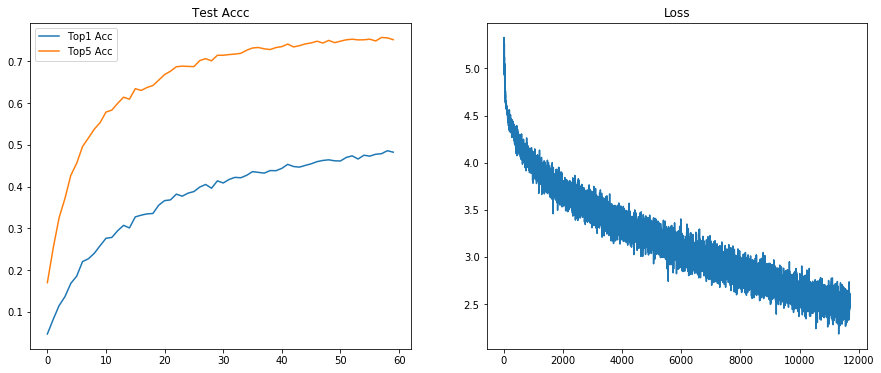

In [25]:
print('Top1/5 Testing Acc =', max([i[0] for i in accs]), max([i[1] for i in accs]))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(accs)
plt.legend(['Top1 Acc','Top5 Acc'])
plt.title('Test Accc')
plt.subplot(1,2,2)
plt.plot(losses)
plt.title('Loss')
plt.show()

In [ ]:
# write the log
from visualdl import LogWriter
writer = LogWriter('work')
for i, v in tqdm(enumerate(losses)):    
    writer.add_scalar(tag="train/loss", step = i, value = v)
for i, v in tqdm(enumerate(accs)):
    writer.add_scalar(tag='valid/top1 acc', step = i, value = v[0])
    writer.add_scalar(tag='valid/top5 acc', step = i, value = v[1])
writer.close()

35100it [00:01, 18185.85it/s]
90it [00:00, 8947.53it/s]


<h2>Visualization</h2>

Visualize the attention map. 可视化注意力图。

Reference: [可视化](https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb)  

The result displayed is based on model trained with patch size = 2. 以下展示结果实际上是在 patch_size = 2 的设定上训练的（需要更久但是分辨率、预测准确率更高）.

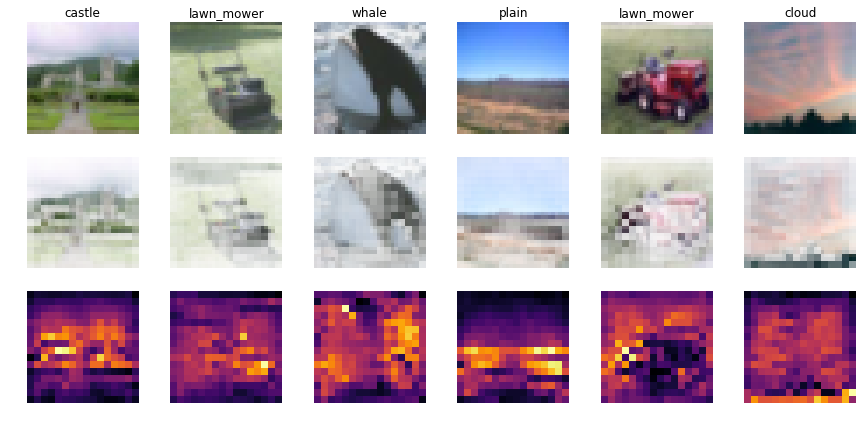

In [19]:
batch_size = 100
np.random.seed(4)
for x, labels in dataloader(data_train['data'], data_train['fine_labels'], verbose = 0,
            augmentation=0, onehot = True, cut = resize[0]//4, mix = 1, grid = 0,
                rotate = 6, resize = resize, batch_size = batch_size):
    imgs, attention = net.visualize(x, layer = 12)
    break 

plt.figure(figsize = (15, 7))
show = 6
for i in range(show):
    plt.subplot(3, show, 1 + i)
    plt.axis('off')
    plt.imshow(x[i].transpose((1,2,0)))
    plt.title(data_meta['fine_label_names'][np.argmax(labels[i])])
    plt.subplot(3, show, show + 1 + i)
    plt.axis('off')
    plt.imshow(imgs[i])
    plt.subplot(3, show, 2*show + 1 + i)
    plt.axis('off')
    plt.imshow(attention[i][0], cmap='inferno')
plt.show()

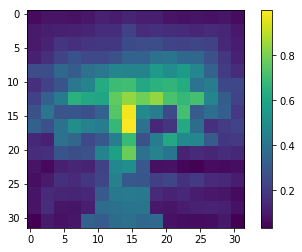

In [ ]:
plt.imshow(attention[0][0])
plt.colorbar()